# Titanic, take 2

Attempting a different approach to the titanic dataset. I'm doing this in a new notebook because the other one was becoming unwieldy.

This time I will try looking at a select set of features - Sex, Age and Pclass.

In [143]:
import pandas as pd
import numpy as np
import seaborn as sns

np.random.seed(0)

df = pd.read_csv("C:/Users/arthu/OneDrive/Documents/GitHub/titanic_survival_predictions/titanic/train.csv")

df_filtered = df.loc[:, ["Survived", "Sex", "Age", "Pclass"]]

I suspect there may be some interesting clusters in the data, because of the "women and children first" policy, i.e. adult females and children of both genders, so the Sex feature plays a different role at different ages.

<AxesSubplot: xlabel='Sex', ylabel='Age'>

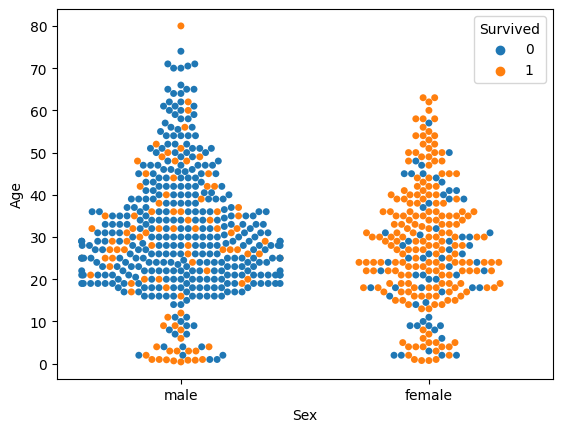

In [144]:
sns.swarmplot(x=df_filtered["Sex"], y=df_filtered["Age"], hue=df_filtered["Survived"])

In [145]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer(
    transformers=[
        ('oh_encode', OneHotEncoder(), ["Sex", "Pclass"]),
        ('fill_median', make_pipeline(SimpleImputer(strategy="median"), StandardScaler()), ["Age"]),
        ('passthrough', "passthrough", ["Survived"])
    ],
    remainder='drop'
)

Xy = preprocessor.fit_transform(df_filtered)
ohe_col_names = preprocessor.named_transformers_["oh_encode"].get_feature_names_out()
col_names = ohe_col_names.tolist() + ["Age", "Survived"]
Xy = pd.DataFrame(Xy, columns=col_names)
Xy

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Age,Survived
0,0.0,1.0,0.0,0.0,1.0,-0.565736,0.0
1,1.0,0.0,1.0,0.0,0.0,0.663861,1.0
2,1.0,0.0,0.0,0.0,1.0,-0.258337,1.0
3,1.0,0.0,1.0,0.0,0.0,0.433312,1.0
4,0.0,1.0,0.0,0.0,1.0,0.433312,0.0
...,...,...,...,...,...,...,...
886,0.0,1.0,0.0,1.0,0.0,-0.181487,0.0
887,1.0,0.0,1.0,0.0,0.0,-0.796286,1.0
888,1.0,0.0,0.0,0.0,1.0,-0.104637,0.0
889,0.0,1.0,1.0,0.0,0.0,-0.258337,1.0


In [146]:
from sklearn.cluster import KMeans

Xy_clusters = Xy.copy()

kmeans = KMeans(n_clusters=10)
Xy_clusters["Cluster"] = kmeans.fit_predict(Xy.drop("Survived", axis=1))
Xy_clusters["Cluster"] = Xy_clusters["Cluster"].astype("category")

Xy_clusters

clusters = Xy_clusters.loc[:, ["Survived", "Cluster"]]

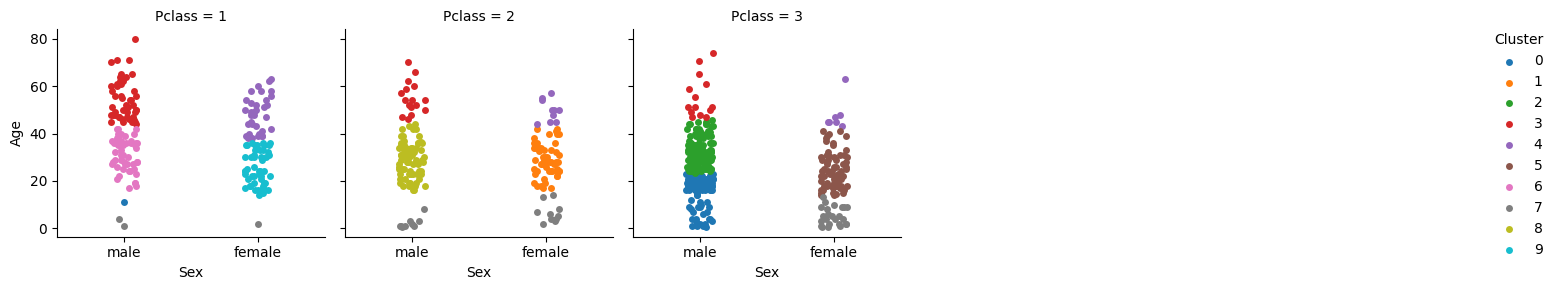

In [147]:
cluster_visualisation_df = df_filtered.join(clusters["Cluster"])

grid = sns.FacetGrid(cluster_visualisation_df, col="Pclass", hue="Cluster", col_wrap=5)
grid.map(sns.stripplot, "Sex", "Age", order=['male', 'female'])

grid.add_legend()

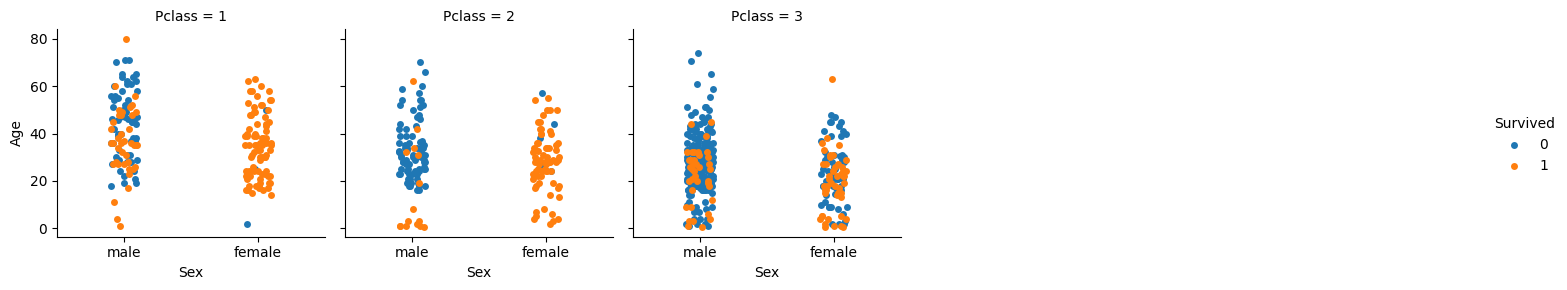

In [148]:
grid = sns.FacetGrid(cluster_visualisation_df, col="Pclass", hue="Survived", col_wrap=5)
grid.map(sns.stripplot, "Sex", "Age", order=['male', 'female'])

grid.add_legend()

<AxesSubplot: xlabel='Cluster', ylabel='Survived'>

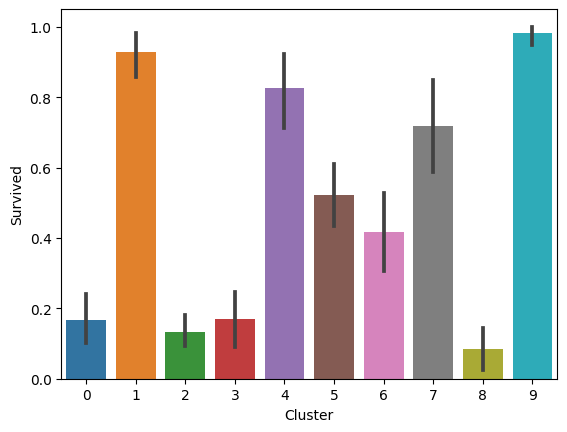

In [149]:
sns.barplot(x=cluster_visualisation_df["Cluster"], y=cluster_visualisation_df["Survived"])

I will now try cross-validation based on three variations of the data:
* Just the set of columns I picked out - Xy
* Those columns plus the clusters - Xy_clusters
* Just the clusters, on their own - clusters

In [150]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)

X = Xy.copy()
y = X.pop("Survived")
scores_Xy = cross_val_score(model, X, y, cv=5, scoring='accuracy')

X_clusters = Xy_clusters.copy()
y_clusters = X_clusters.pop("Survived")
scores_Xy_clusters = cross_val_score(model, X_clusters, y_clusters, cv=5, scoring='accuracy')

X_clusters_only = clusters.copy()
y_clusters_only = X_clusters_only.pop("Survived")
scores_clusters_only = cross_val_score(model, X_clusters_only, y_clusters_only, cv=5, scoring='accuracy')

print("Scores: "
      + "\nXy: " + str(scores_Xy) + "; mean is " + str(scores_Xy.mean())
      + "\nXy_clusters: " + str(scores_Xy_clusters) + "; mean is " + str(scores_Xy_clusters.mean())
      + "\nClusters only: " + str(scores_clusters_only) + "; mean is " + str(scores_clusters_only.mean())
     )

Scores: 
Xy: [0.75977654 0.80898876 0.80898876 0.82022472 0.81460674]; mean is 0.8025171050153789
Xy_clusters: [0.75418994 0.80337079 0.80337079 0.83707865 0.81460674]; mean is 0.8025233820852427
Clusters only: [0.75418994 0.81460674 0.79775281 0.75842697 0.80337079]; mean is 0.785669449500973


It appears that (for the random forest algorithm, at least) the dataset which includes the clusters alongside the other data is the best option. I will now use this data and model to generate some predictions.

In [152]:
model.fit(X_clusters, y_clusters)

X_test = pd.read_csv("C:/Users/arthu/OneDrive/Documents/GitHub/titanic_survival_predictions/titanic/test.csv")
pax_id = X_test["PassengerId"]
preprocessor_final = ColumnTransformer(
    transformers=[
        ('oh_encode', OneHotEncoder(), ["Sex", "Pclass"]),
        ('fill_median', make_pipeline(SimpleImputer(strategy="median"), StandardScaler()), ["Age"]),
    ],
    remainder='drop'
)
X_test = preprocessor_final.fit_transform(X_test)
ohe_col_names = preprocessor_final.named_transformers_["oh_encode"].get_feature_names_out()
col_names = ohe_col_names.tolist() + ["Age"]
X_test = pd.DataFrame(X_test, columns=col_names)
X_test["Cluster"] = kmeans.predict(X_test)
X_test["Cluster"] = X_test["Cluster"].astype("category")
predictions = model.predict(X_test).astype(int)
output = pd.DataFrame({'PassengerId': pax_id, 'Survived': predictions})

output.to_csv("C:/Users/arthu/OneDrive/Documents/GitHub/titanic_survival_predictions/titanic/predictions2.csv", index=False)

output

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,1
...,...,...
413,1305,1
414,1306,1
415,1307,0
416,1308,1
